In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import datetime
import category_encoders as ce

In [25]:
#Set parameter

dataset = 'test'

#Load data
data_ = pd.read_csv("data/" + dataset + ".csv")
data = data_.copy()

In [26]:
#First look
display(data.head(5))
data.shape

,ID,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15
0,425552,2020-01-23 01:26:00,2020-01-23 02:52:00,2020-01-22 20:26:00,2020-01-22 21:52:00,LGA,12953,BGR,10581,N8894A,9E,20363,5032,378.0,0,NaN
1,415418,2020-01-23 01:26:00,2020-01-23 03:04:00,2020-01-22 19:26:00,2020-01-22 22:04:00,MDW,13232,PHL,14100,N8615E,WN,19393,1168,668.0,0,NaN
2,414222,2020-01-23 01:26:00,2020-01-23 03:06:00,2020-01-22 18:26:00,2020-01-22 19:06:00,DEN,11292,LAS,12889,N7853B,WN,19393,799,628.0,0,NaN
3,421432,2020-01-23 01:26:00,2020-01-23 02:48:00,2020-01-22 17:26:00,2020-01-22 18:48:00,SJC,14831,SAN,14679,N7812G,WN,19393,4454,417.0,0,0.0
4,421356,2020-01-23 01:26:00,2020-01-23 02:24:00,2020-01-22 17:26:00,2020-01-22 18:24:00,SJC,14831,BUR,10800,N7859B,WN,19393,2024,296.0,0,NaN


(179781, 16)

In [27]:
#Find columns with nulls values
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

DISTANCE      7550
DEP_DEL15    62923
dtype: int64

In [28]:
data.count()

ID                       179781
DATE_DEPARTURE_UTC       179781
DATE_ARRIVAL_UTC         179781
DATE_DEPARTURE_LCL       179781
DATE_ARRIVAL_LCL         179781
ORIGIN                   179781
ORIGIN_AIRPORT_ID        179781
DEST                     179781
DEST_AIRPORT_ID          179781
TAIL_NUM                 179781
OP_CARRIER               179781
OP_CARRIER_AIRLINE_ID    179781
OP_CARRIER_FL_NUM        179781
DISTANCE                 172231
CANCELLED                179781
DEP_DEL15                116858
dtype: int64

In [29]:
#Analyze column Cancelled
data['CANCELLED'].value_counts()

0    179781
Name: CANCELLED, dtype: int64

In [30]:
#Identify columns to drop considering:
#Redundant columns - IDs vs Names, local and utc times
#Columns with same values (cancelled)
to_drop = ['DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL', 'CANCELLED', 'ORIGIN', 'DEST', 'OP_CARRIER']

In [31]:
df = data.drop(to_drop, axis=1)

In [32]:
df.dtypes

ID                         int64
DATE_DEPARTURE_UTC        object
DATE_ARRIVAL_UTC          object
ORIGIN_AIRPORT_ID          int64
DEST_AIRPORT_ID            int64
TAIL_NUM                  object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER_FL_NUM          int64
DISTANCE                 float64
DEP_DEL15                float64
dtype: object

In [33]:
#Set ID as Index
df = df.set_index('ID')

In [34]:
print(df_date_sep.head())

       Date_Departure Hours_Departure
ID                                   
425552       20200123        01:26:00
415418       20200123        01:26:00
414222       20200123        01:26:00
421432       20200123        01:26:00
421356       20200123        01:26:00


# Datetime special treatment

In [35]:
#Split the data Departure
df_date_sep = df.DATE_DEPARTURE_UTC.str.split(pat=' ', expand=True)
df_date_sep.columns = ['Date_Departure', 'Hours_Departure']
df_date_sep_hour = df_date_sep.Hours_Departure.str.split(pat=':', expand=True)
df_date_sep_hour.columns = ['hours','minute','second']


#Convert Departure Data to datetime
df_date_sep['Date_Departure']= df_date_sep['Date_Departure'].str.replace('-','')
df_date_sep['Hours_Departure'] = df['Hours_Departure']= df_date_sep_hour['hours'].values

#Add Departure data to df
df['Date_Departure']= df_date_sep['Date_Departure'].values
df['Hours_Departure'] = df_date_sep['Hours_Departure'].values

#Split the data Arrival
df_date_sep = df.DATE_ARRIVAL_UTC.str.split(pat=' ', expand=True)
df_date_sep.columns = ['Date_Arrival', 'Hours_Arrival']

#Convert Arrival Data to datetime
df_date_sep['Date_Arrival']= df_date_sep['Date_Arrival'].str.replace('-','')
df_date_sep['Hours_Arrival'] = df['Hours_Departure']= df_date_sep_hour['hours'].values


Convert Arrival Data to datetime
df_date_sep['Date_Arrival']= df_date_sep['Date_Arrival'].str.replace('-','')
df_date_sep['Hours_Arrival'] = df['Hours_Departure']= df_date_sep_hour['hours'].values




# Numerical variabels

In [36]:
#check correlation
cor_df = df.corr()
lower_triangle_mask = np.triu(np.ones(cor_df.shape)).astype(np.bool)
cor_df_lower = cor_df.mask(lower_triangle_mask)
plt.figure(figsize = (12,8))
sns.heatmap(cor_df_lower, annot = True, cmap = "RdBu_r")

NameError: name 'sns' is not defined

<Figure size 864x576 with 0 Axes>

### Fill nulls

In [37]:
df['DEP_DEL15'] = df['DEP_DEL15'].fillna(0)

In [38]:
df['DEP_DEL15'].value_counts()

0.0    166952
1.0     12829
Name: DEP_DEL15, dtype: int64

In [39]:
#NICE TO HAVE
"""
"tailnums = df['TAIL_NUM'].unique()

for tn in tailnums:
    df.loc[df['TAIL_NUM'] == tn]['DISTANCE'].mean()
"""

'\n"tailnums = df[\'TAIL_NUM\'].unique()\n\nfor tn in tailnums:\n    df.loc[df[\'TAIL_NUM\'] == tn][\'DISTANCE\'].mean()\n'

In [40]:
mean = df['DISTANCE'].mean()
df['DISTANCE'] = df['DISTANCE'].fillna(mean)

In [41]:
#Check if there are no remaining nulls
df.count()

ORIGIN_AIRPORT_ID        179781
DEST_AIRPORT_ID          179781
TAIL_NUM                 179781
OP_CARRIER_AIRLINE_ID    179781
OP_CARRIER_FL_NUM        179781
DISTANCE                 179781
DEP_DEL15                179781
Hours_Departure          179781
Date_Departure           179781
Date_Arrival             179781
Hours_Arrival            179781
dtype: int64

# Categorical features

In [42]:
#Convert to category type
df = df.assign(TAIL_NUM=df['TAIL_NUM'].astype('category'))

In [43]:
df.dtypes

ORIGIN_AIRPORT_ID           int64
DEST_AIRPORT_ID             int64
TAIL_NUM                 category
OP_CARRIER_AIRLINE_ID       int64
OP_CARRIER_FL_NUM           int64
DISTANCE                  float64
DEP_DEL15                 float64
Hours_Departure            object
Date_Departure             object
Date_Arrival               object
Hours_Arrival              object
dtype: object

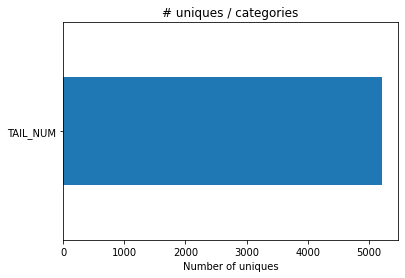

TAIL_NUM    5218
dtype: int64

In [44]:
#Check for unique values
categoricals = df.select_dtypes(include='category').columns
categoricals

number_of_uniques_per_category = df.loc[:, categoricals].nunique()

# little plot 
number_of_uniques_per_category.plot(kind='barh',
                                    title='# uniques / categories');
plt.xlabel('Number of uniques')
plt.show()


number_of_uniques_per_category

# Pipeline - scalling & encoding

## Scalling

In [45]:
df.dtypes

ORIGIN_AIRPORT_ID           int64
DEST_AIRPORT_ID             int64
TAIL_NUM                 category
OP_CARRIER_AIRLINE_ID       int64
OP_CARRIER_FL_NUM           int64
DISTANCE                  float64
DEP_DEL15                 float64
Hours_Departure            object
Date_Departure             object
Date_Arrival               object
Hours_Arrival              object
dtype: object

In [46]:
numericals = df.select_dtypes(include=['int64','float64']).columns

In [47]:
df[numericals].describe()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,DEP_DEL15
count,179781.000000,179781.000000,179781.000000,179781.000000,179781.000000,179781.000000
mean,12653.169234,12655.366346,19995.097535,2591.377287,790.853348,0.071359
std,1524.265549,1526.011750,374.426332,1811.552094,572.064589,0.257424
min,10135.000000,10135.000000,19393.000000,1.000000,31.000000,0.000000
25%,11292.000000,11292.000000,19790.000000,1054.000000,373.000000,0.000000
50%,12889.000000,12889.000000,19977.000000,2139.000000,657.000000,0.000000
75%,14027.000000,14027.000000,20368.000000,4070.000000,1011.000000,0.000000
max,16869.000000,16869.000000,20452.000000,6860.000000,5095.000000,1.000000


In [48]:
##SCALE DE VARIAVEIS NUMERICAS

from sklearn.preprocessing import RobustScaler

#Features to scale

scale_list = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM']


for f in scale_list:
    # initialize transformer with desired options
    robustscaler = RobustScaler()

    # save data to scale
    X_rbs = df[[f]]

    # fit transformer to data
    robustscaler.fit(X_rbs)

    # create new feature by transforming the data
    col_new_name = f + '_robust_scaled'
    df[f] = robustscaler.transform(X_rbs)


#drop original columns
df.drop(scale_list, axis = 1)
df

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,DEP_DEL15,Hours_Departure,Date_Departure,Date_Arrival,Hours_Arrival
ID,,,,,,,,,,,
425552,0.023400,-0.843876,N8894A,0.667820,0.959218,378.0,0.0,01,20200123,20200123,01
415418,0.125411,0.442779,N8615E,-1.010381,-0.321950,668.0,0.0,01,20200123,20200123,01
414222,-0.583912,0.000000,N7853B,-1.010381,-0.444297,628.0,0.0,01,20200123,20200123,01
421432,0.710055,0.654479,N7812G,-1.010381,0.767573,417.0,0.0,01,20200123,20200123,01
421356,0.710055,-0.763803,N7859B,-1.010381,-0.038130,296.0,0.0,01,20200123,20200123,01
...,...,...,...,...,...,...,...,...,...,...,...
595550,-0.047898,0.688117,N77430,0.000000,-0.137599,2367.0,0.0,09,20200201,20200201,09
605277,0.034004,0.001097,N544US,-0.323529,-0.251326,2615.0,0.0,09,20200201,20200201,09
588211,-0.047898,0.679342,N566AS,-0.081315,-0.417440,2688.0,1.0,09,20200201,20200201,09


## Encoding

In [49]:
#ENCODING VARIAVEIS CATEGORICAS

encoder = ce.ordinal.OrdinalEncoder()

X2 = df[['TAIL_NUM']]
encoder.fit(X2)

df['TAIL_NUM_Encode'] = encoder.transform(X2)
df = df.drop('TAIL_NUM',axis=1)

In [51]:
## CRIAR PIPELINE
"""
# now let's make the pipeline
pipeline = make_pipeline(
    RemoveObjectColumns(),
    # it's cool how scikit already has a mean imputer ready to go!
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=10)
)

# No need for us to manually preprocess the X_train at all
pipeline.fit(X_train, y_train)

# Same thing for X_test
probas = pipeline.predict_proba(X_test)
"""

print(df.dtypes)

ORIGIN_AIRPORT_ID        float64
DEST_AIRPORT_ID          float64
OP_CARRIER_AIRLINE_ID    float64
OP_CARRIER_FL_NUM        float64
DISTANCE                 float64
DEP_DEL15                float64
Hours_Departure           object
Date_Departure            object
Date_Arrival              object
Hours_Arrival             object
TAIL_NUM_Encode            int64
dtype: object


In [52]:
df.to_csv('data/' + dataset + '_worked.csv')

df.groupby('age').size()